<a href="https://colab.research.google.com/github/Wqcapstone1234/Enhancing-Basic-VIX-Strategy/blob/main/MScFE_690_Capstone_Code_Group_9171.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
#Install required packages
!pip install ta
!pip install hmmlearn
!pip install arch
!pip install yfinance --upgrade
!pip install tensorflow scikit-learn

In [ ]:
#Import libraries
import yfinance as yf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import time

from ta.momentum import RSIIndicator
from arch import arch_model
from statsmodels.tsa.stattools import ccf
from hmmlearn import hmm
import statsmodels.api as sm

import random
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Data Collection and Preprocessing

In [ ]:
#Download data from YFinance
#Data downloaded period select from 2014-2024

start_date = datetime.date(2014, 1, 1)
end_date   = datetime.date(2024, 12, 31)
VOO        = yf.download(['VOO'], start_date, end_date)
VIX        = yf.download(['^VIX'], start_date, end_date)
VOO_close  = VOO[['Close']]
VIX_close  = VIX[['Close']]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
#Checking missing data from the downloaded data

df = pd.concat([VOO['Close'], VIX['Close']],axis=1)
print('Number of missing data:')
print(df.isna().sum())

Number of missing data:
Ticker
VOO     0
^VIX    0
dtype: int64


# Exploratory Data Analysis

In [ ]:
#Basic Statistics summary
df.describe()

Ticker,VOO,^VIX
count,2767.000000,2767.000000
mean,274.045870,17.896169
std,109.049003,7.087609
min,131.259384,9.140000
25%,171.470505,13.195000
50%,240.832565,15.940000
75%,364.273376,20.795000
max,555.112488,82.690002


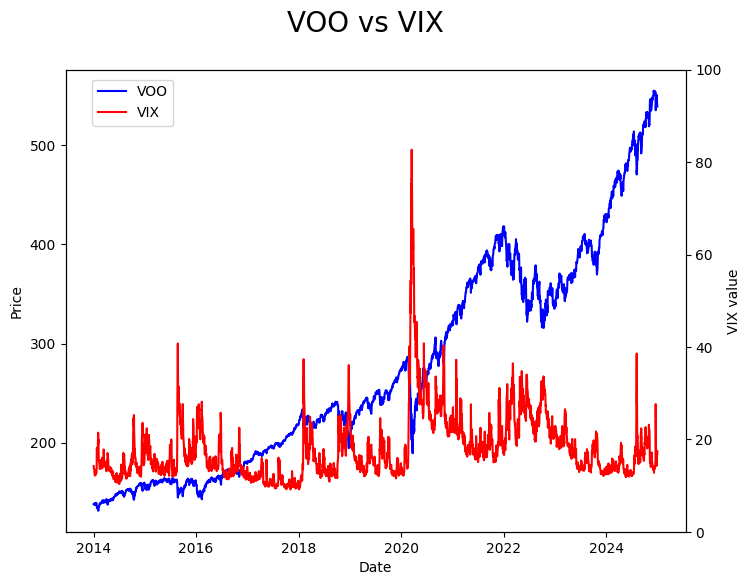

In [ ]:
#Ploting the historical value of VOO and VIX in the selected period
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()
ax2.set_ylim(0, 100)

# Plot lines with labels
ax1.plot(df.index, df['VOO'], color='b', label='VOO')
ax2.plot(df.index, df['^VIX'], color='r', label='VIX')

ax1.set_xlabel("Date")
ax1.set_ylabel("Price")
ax2.set_ylabel("VIX value")

fig.suptitle("VOO vs VIX", fontsize=20)

# Get legend handles and labels from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Combine handles and labels
handles = handles1 + handles2
labels = labels1 + labels2

# Create a single legend for the figure
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.15, 0.875))

# Display the plot
plt.show()


In [ ]:
#Calculate the pct change for VOO and VIX
df['VOO pct change'] = df['VOO'].pct_change()
df['VIX pct change'] = df['^VIX'].pct_change()
df['VOO pct change sd'] = df['VOO'].pct_change().rolling(10).std()
df['VIX pct change sd'] = df['^VIX'].pct_change().rolling(10).std()

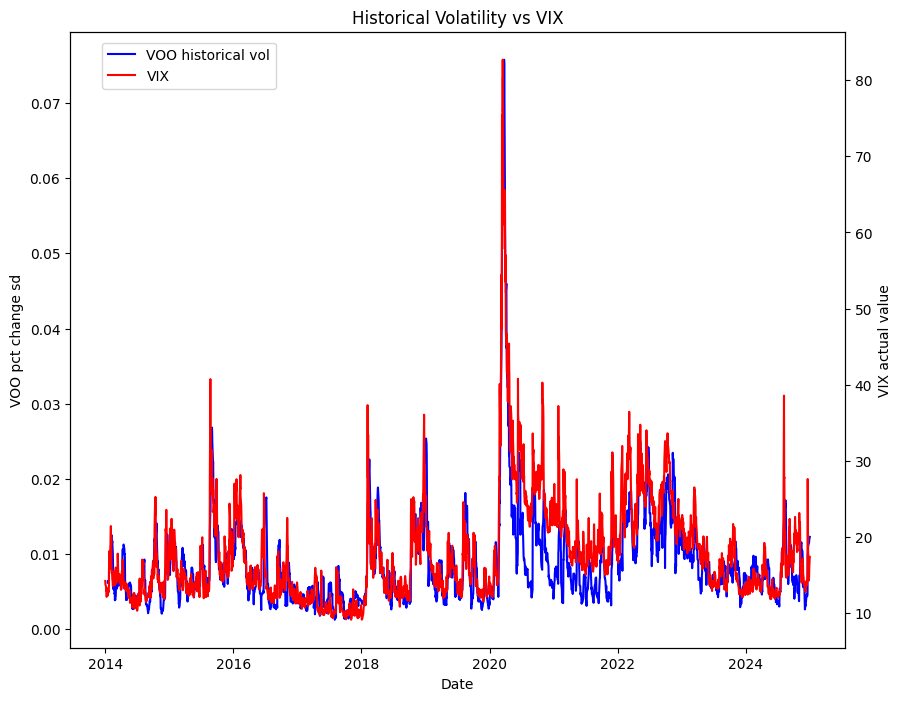

In [ ]:
#Ploting historical volatility vs VIX
fig, ax1 = plt.subplots(figsize=(10, 8))
ax2 = ax1.twinx()
ax1.plot(df.index,df['VOO pct change sd'],color ='b', label = 'VOO historical vol')
ax2.plot(df.index, df['^VIX'],color = 'r', label = 'VIX')


ax1.set_xlabel("Date")
ax1.set_ylabel("VOO pct change sd")
ax2.set_ylabel("VIX actual value")

# Get legend handles and labels from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Combine handles and labels
handles = handles1 + handles2
labels = labels1 + labels2

# Create a single legend for the figure
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.15, 0.875))

plt.title("Historical Volatility vs VIX")

plt.show()

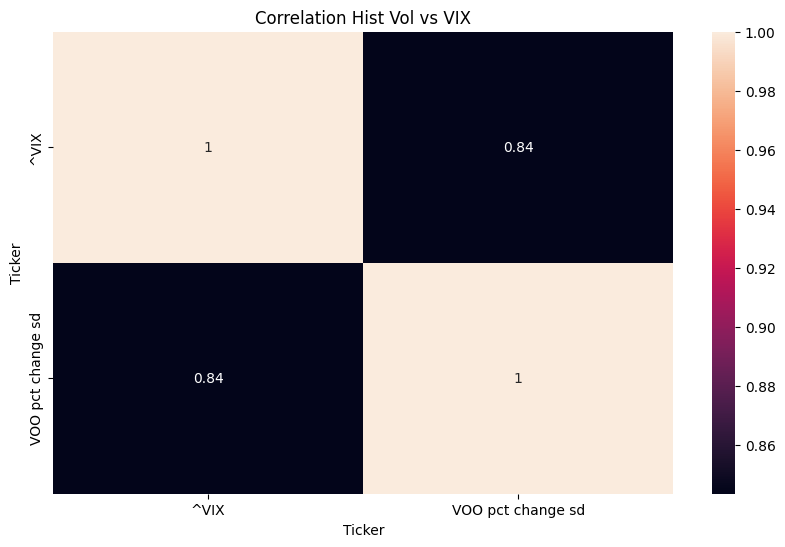

In [ ]:
#Plot correlation matrix for VIX and historical volatility
df_corr_1 = df[['^VIX','VOO pct change sd']]
plt.figure(figsize=(10,6))
c = df_corr_1.corr()
sns.heatmap(c, annot=True)
plt.title("Correlation Hist Vol vs VIX")
plt.show()

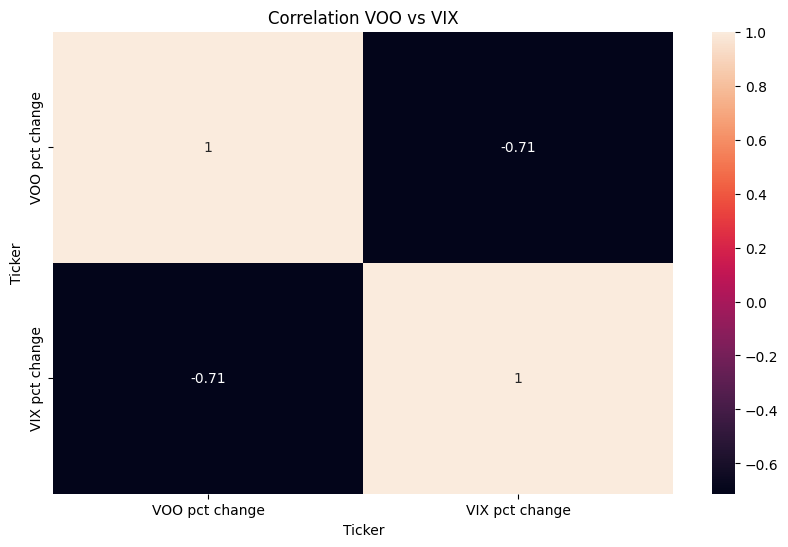

In [ ]:
#Plot correlation matrix for VOO and VIX pct change
df_corr_2 = df[['VOO pct change','VIX pct change']]
plt.figure(figsize=(10,6))
c = df_corr_2.corr()
sns.heatmap(c, annot=True)
plt.title("Correlation VOO vs VIX")
plt.show()

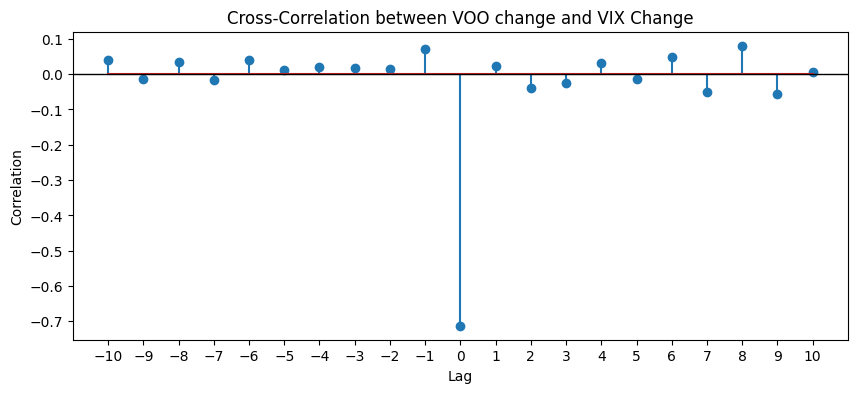

In [ ]:
max_lag = 10

# Calculate cross-correlation
lags = np.arange(-10, 11)
cross_corrs = [df['VOO pct change'].corr(df['VIX pct change'].shift(lag)) for lag in lags]

# Plot cross-correlation
plt.figure(figsize=(10, 4))
plt.stem(lags, cross_corrs)
plt.axhline(0, color='black', lw=1)
plt.xticks(np.arange(-max_lag, max_lag + 1, 1))
plt.title('Cross-Correlation between VOO change and VIX Change')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()

# Regime Analysis on the VIX level

In [ ]:
# Ensure ^VIX column has no NaNs before fitting
df = df.dropna(subset=['^VIX']).copy()

# Use VIX values from df directly
vix_values = df['^VIX'].values

# Discretize VIX for HMM input
vix_discretized = np.digitize(vix_values, bins=np.linspace(vix_values.min(), vix_values.max(), 20)).reshape(-1, 1)

# Fit HMM model
model = hmm.GaussianHMM(n_components=2, covariance_type="diag", n_iter=10000)
model.fit(vix_discretized)
hidden_states = model.predict(vix_discretized)

# Assign regime back to df by position
df['Regime'] = hidden_states

# Calculate percentiles within each regime using the same vix_values
regime_0_vix_mean = np.percentile(vix_values[hidden_states == 0], 10)
regime_1_vix_mean = np.percentile(vix_values[hidden_states == 1], 90)

print(f"Regime 0 VIX (10th percentile): {regime_0_vix_mean:.2f}")
print(f"Regime 1 VIX (90th percentile): {regime_1_vix_mean:.2f}")


Regime 0 VIX (10th percentile): 11.04
Regime 1 VIX (90th percentile): 31.00


# Backtesting for VIX-only baseline Strategy

In [ ]:
#Function of VIX-only baseline Strategy
def backtest_base(df,buy_threshold, sell_threshold, direction):
  df['VIX base Position'] = 0  # Initialize a column to track positions (0: no position, 1: long)

  trade_count = 0

  positions = [0]
  # Loop through the data to generate signals
  # Use df.index to access rows by their actual index values (dates)
  if direction == 'up':
    for i in df.index[1:]:  # Start from the second row to avoid issues with previous values
        if df.loc[i,'^VIX'] > buy_threshold : # Access the previous row's 'Position' using index location
            positions.append(1)
            trade_count += 1
        elif df.loc[i,'^VIX'] < sell_threshold : # Access the previous row's 'Position' using index location
            positions.append(-1)
            trade_count += 1
        else:
            positions.append(positions[-1])

  elif direction == 'down' :
      for i in df.index[1:]:  # Start from the second row to avoid issues with previous values
        if df.loc[i,'^VIX'] < buy_threshold : # Access the previous row's 'Position' using index location
            positions.append(1)
            trade_count += 1
        elif df.loc[i,'^VIX'] > sell_threshold : # Access the previous row's 'Position' using index location
            positions.append(-1)
            trade_count += 1
        else:
            positions.append(positions[-1])



  # Calculate daily returns based on the strategy
  df['VIX base Position'] = positions
  df['VIX base Strategy_Returns'] = df['VOO'].pct_change() * df['VIX base Position'].shift(1) #shift because we enter a position at the end of the day
  df['VIX base Strategy_Returns'] = df['VIX base Strategy_Returns'].fillna(0) #first day will be Nan

  annualized_vol = df['VIX base Strategy_Returns'].std() * np.sqrt(252)
  sharpe = df['VIX base Strategy_Returns'].mean() / annualized_vol * np.sqrt(252)

  # Calculate cumulative returns for the strategy and the benchmark
  df['Cumulative_VIX_base_Strategy_Returns'] = (1 + df['VIX base Strategy_Returns']).cumprod()
  df['Cumulative_VOO_Returns'] = (1 + df['VOO'].pct_change()).cumprod()

  cumulative = df['Cumulative_VIX_base_Strategy_Returns']

  drawdown = (cumulative.cummax() - cumulative).max()

  # Evaluate Performance (example metrics)
  strategy_total_return = (df['Cumulative_VIX_base_Strategy_Returns'].iloc[-1] - 1) * 100

  num_trade = int((df['VIX base Position'].diff().fillna(0) != 0).sum())

  return {
        'Direction' : direction,
        'Buy threshold': buy_threshold,
        'Sell threshold': sell_threshold,
        'Total Return': f"{strategy_total_return:.2f}%",
        'Sharpe Ratio': f"{sharpe:.2f}",
        'Max Drawdown': f"{drawdown*100:.2f}%",
        'Trades': num_trade
  }

In [ ]:
#Conduct a grid seearch of different threhold to determine optimal threshold
metrics_VIX_base = []
direction_list = ['up','down']
buy_threshold_range = [10, 12, 15, 20, 30, 40]
sell_threshold_range = [10, 12, 15, 20, 30, 40]
for direction in direction_list:
  for buy_threshold in buy_threshold_range:
    for sell_threshold in sell_threshold_range:
      metrics_VIX_base.append(backtest_base(df,buy_threshold, sell_threshold,direction))

summary_VIX_df = pd.DataFrame(metrics_VIX_base)
summary_VIX_df.index.name = None
print(summary_VIX_df)
summary_VIX_df.to_csv('metrics_VIX_base.csv')

   Direction  Buy threshold  Sell threshold Total Return Sharpe Ratio  \
0         up             10              10      243.36%         0.05   
1         up             10              12      243.36%         0.05   
2         up             10              15      243.36%         0.05   
3         up             10              20      243.36%         0.05   
4         up             10              30      243.36%         0.05   
..       ...            ...             ...          ...          ...   
67      down             40              12      226.07%         0.04   
68      down             40              15      226.07%         0.04   
69      down             40              20      226.07%         0.04   
70      down             40              30      226.07%         0.04   
71      down             40              40      226.07%         0.04   

   Max Drawdown  Trades  
0        65.31%      37  
1        65.31%      37  
2        65.31%      37  
3        65.31%    

In [ ]:
#Selected Threshold for VIX Base Strategy
buy_threshold = 20
sell_threshold = 12
direction = 'up'
backtest_base(df,buy_threshold, sell_threshold, direction)

{'Direction': 'up',
 'Buy threshold': 20,
 'Sell threshold': 12,
 'Total Return': '194.87%',
 'Sharpe Ratio': '0.04',
 'Max Drawdown': '57.79%',
 'Trades': 17}

In [ ]:
#Store return in to compare dataframe
df_compare = pd.DataFrame()
df_compare['VIX base Position'] = df['VIX base Position']
df_compare['VIX base Strategy_Returns'] = df['VIX base Strategy_Returns']
df_compare['Cumulative_VIX_base_Strategy_Returns'] = df['Cumulative_VIX_base_Strategy_Returns']

# Backtesting for VIX+RSI hybrid Strategy

In [ ]:
#Calculate RSI data, default using 14 as the window
df ['VOO RSI']       = RSIIndicator(close = df['VOO'], window =14).rsi()
df ['VIX RSI']       = RSIIndicator(close = df['^VIX'], window =14).rsi()

In [ ]:
#Backtesting with VIX and RSI filter
def backtest_RSI(df,buy_threshold, sell_threshold, RSI_buy_threshold, RSI_sell_threshold, direction):
  df['VIX RSI Position'] = 0  # Initialize a column to track positions (0: no position, 1: long)

  trade_count = 0

  positions = [0]
  # Loop through the data to generate signals
  # Use df.index to access rows by their actual index values (dates)
  if direction == 'up':
    for i in df.index[1:]:  # Start from the second row to avoid issues with previous values
        if df.loc[i,'^VIX'] > buy_threshold and df.loc[i,'VIX RSI'] > RSI_buy_threshold : # Access the previous row's 'Position' using index location
            positions.append(1)
            trade_count += 1
        elif df.loc[i,'^VIX'] < sell_threshold and df.loc[i,'VIX RSI'] < RSI_sell_threshold: # Access the previous row's 'Position' using index location
            positions.append(-1)
            trade_count += 1
        else:
            positions.append(positions[-1])
  elif direction == 'down':
    for i in df.index[1:]:  # Start from the second row to avoid issues with previous values
      if df.loc[i,'^VIX'] > buy_threshold and df.loc[i,'VIX RSI'] < RSI_buy_threshold : # Access the previous row's 'Position' using index location
          positions.append(1)
          trade_count += 1
      elif df.loc[i,'^VIX'] < sell_threshold and df.loc[i,'VIX RSI'] > RSI_sell_threshold: # Access the previous row's 'Position' using index location
          positions.append(-1)
          trade_count += 1
      else:
          positions.append(positions[-1])

  df['VIX RSI Position'] = positions
  # Calculate daily returns based on the strategy
  df['VIX RSI Strategy_Returns'] = df['VOO'].pct_change() * df['VIX RSI Position'].shift(1) #shift because we enter a position at the end of the day
  df['VIX RSI Strategy_Returns'] = df['VIX RSI Strategy_Returns'].fillna(0) #first day will be Nan

  annualized_vol = df['VIX RSI Strategy_Returns'].std() * np.sqrt(252)
  sharpe = df['VIX RSI Strategy_Returns'].mean() / annualized_vol * np.sqrt(252)

  # Calculate cumulative returns for the strategy and the benchmark
  df['Cumulative_VIX_RSI_Strategy_Returns'] = (1 + df['VIX RSI Strategy_Returns']).cumprod()
  df['Cumulative_VOO_Returns'] = (1 + df['VOO'].pct_change()).cumprod()

  cumulative = df['Cumulative_VIX_RSI_Strategy_Returns']

  drawdown = (cumulative.cummax() - cumulative).max()

  # Evaluate Performance (example metrics)
  strategy_total_return = (df['Cumulative_VIX_RSI_Strategy_Returns'].iloc[-1] - 1) * 100

  num_trade = int((df['VIX RSI Position'].diff().fillna(0) != 0).sum())

  return {
        'Direction' : direction,
        'Buy threshold': buy_threshold,
        'Sell threshold': sell_threshold,
        'RSI buy threshold': RSI_buy_threshold,
        'RSI sell threshold': RSI_sell_threshold,
        'Total Return': f"{strategy_total_return:.2f}%",
        'Sharpe Ratio': f"{sharpe:.2f}",
        'Max Drawdown': f"{drawdown*100:.2f}%",
        'Trades': num_trade
  }

In [ ]:
#Conduct a grid seearch of different threhold to determine optimal threshold
metrics_VIX_RSI = []

RSI_buy_threshold_range = [30, 50, 70]
RSI_sell_threshold_range = [30, 50, 70]
direction_list = ['up', 'down']
for direction in direction_list:
  for RSI_buy_threshold in RSI_buy_threshold_range:
    for RSI_sell_threshold in RSI_sell_threshold_range:
      metrics_VIX_RSI.append(backtest_RSI(df, buy_threshold, sell_threshold, RSI_buy_threshold, RSI_sell_threshold, direction))

metrics_VIX_RSI_df = pd.DataFrame(metrics_VIX_RSI)
metrics_VIX_RSI_df.index.name = None
print(metrics_VIX_RSI_df)
metrics_VIX_RSI_df.to_csv('metrics_VIX_RSI.csv')

   Direction  Buy threshold  Sell threshold  RSI buy threshold  \
0         up             20              12                 30   
1         up             20              12                 30   
2         up             20              12                 30   
3         up             20              12                 50   
4         up             20              12                 50   
5         up             20              12                 50   
6         up             20              12                 70   
7         up             20              12                 70   
8         up             20              12                 70   
9       down             20              12                 30   
10      down             20              12                 30   
11      down             20              12                 30   
12      down             20              12                 50   
13      down             20              12                 50   
14      do

In [ ]:
#Selected Threshold for VIX and RSI Hybrid Strategy
RSI_buy_threshold = 70
RSI_sell_threshold = 50
direction = 'up'
backtest_RSI(df,buy_threshold, sell_threshold,RSI_buy_threshold,RSI_sell_threshold, direction)

{'Direction': 'up',
 'Buy threshold': 20,
 'Sell threshold': 12,
 'RSI buy threshold': 70,
 'RSI sell threshold': 50,
 'Total Return': '204.72%',
 'Sharpe Ratio': '0.04',
 'Max Drawdown': '59.72%',
 'Trades': 17}

In [ ]:
#Store return in to compare dataframe
df_compare['VIX RSI Position'] = df['VIX RSI Position']
df_compare['VIX RSI Strategy_Returns'] = df['VIX RSI Strategy_Returns']
df_compare['Cumulative_VIX_RSI_Strategy_Returns'] = df['Cumulative_VIX_RSI_Strategy_Returns']

# GARCH model analysis

In [ ]:
df_garch = df.copy()
df_garch = df_garch.dropna()
#Define possible value of paramter p and q for the GARCH model
p_range = range(1, 5)
q_range = range(1, 5)
min_bic = 1e8
selected_orders = (0, 0)

#GARCH model selection
garch_select = []

#Run a for-loop for GARCH model to select the p and q paramter with AIC and BIC
for p in p_range:
    for q in q_range:
        # GARCH(p,q) model
        model = arch_model(
            df_garch['VIX pct change'],
            mean='Zero',
            vol='GARCH',
            p=p, q=q,
            dist='StudentsT',
            rescale=True,
            )
        res = model.fit(disp='off')
        model = {'Model':f'GARCH({p},{q})',
                  'AIC': round(res.aic,2),
                   'BIC': round(res.bic,2)}
        garch_select.append(model)
        if res.bic < min_bic:
            min_bic = res.bic
            selected_orders = (p, q)
p, q = selected_orders
garch_select_df = pd.DataFrame(garch_select)
garch_select_df.index.name = None
print(garch_select_df)
print(f'Selected model with BIC : p={p} and q={q}')
garch_select_df.to_csv('garch_select.csv')

         Model      AIC      BIC
0   GARCH(1,1)  5908.23  5931.92
1   GARCH(1,2)  5910.23  5939.84
2   GARCH(1,3)  5912.23  5947.75
3   GARCH(1,4)  5914.09  5955.53
4   GARCH(2,1)  5909.45  5939.06
5   GARCH(2,2)  5910.18  5945.70
6   GARCH(2,3)  5912.09  5953.53
7   GARCH(2,4)  5913.55  5960.92
8   GARCH(3,1)  5911.45  5946.98
9   GARCH(3,2)  5912.18  5953.62
10  GARCH(3,3)  5914.09  5961.45
11  GARCH(3,4)  5915.54  5968.83
12  GARCH(4,1)  5913.45  5954.90
13  GARCH(4,2)  5914.18  5961.54
14  GARCH(4,3)  5916.09  5969.37
15  GARCH(4,4)  5917.52  5976.73
Selected model with BIC : p=1 and q=1


In [ ]:
# GARCH(1,1) Model with Student's t White Noise
garch11_t_spec = arch_model(
    df_garch['VIX pct change'],
    vol="GARCH",
    p=1,
    q=1,
    mean="AR",
    dist='StudentsT',
    rescale=True,
)
garch11_t_fit = garch11_t_spec.fit()
garch11_t_fit.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 102878.19309479141
Iteration:      2,   Func. Count:     19,   Neg. LLF: 41599.361251845214
Iteration:      3,   Func. Count:     26,   Neg. LLF: 5580.34637180666
Iteration:      4,   Func. Count:     33,   Neg. LLF: 4139.116682276273
Iteration:      5,   Func. Count:     40,   Neg. LLF: 4355.754368570051
Iteration:      6,   Func. Count:     49,   Neg. LLF: 3006.773892106699
Iteration:      7,   Func. Count:     56,   Neg. LLF: 4957.684371939407
Iteration:      8,   Func. Count:     63,   Neg. LLF: 2957.798712817632
Iteration:      9,   Func. Count:     70,   Neg. LLF: 2943.4393060491984
Iteration:     10,   Func. Count:     76,   Neg. LLF: 2942.993333045809
Iteration:     11,   Func. Count:     82,   Neg. LLF: 2942.945571686656
Iteration:     12,   Func. Count:     88,   Neg. LLF: 2942.9406233766176
Iteration:     13,   Func. Count:     94,   Neg. LLF: 2942.9402782462253
Iteration:     14,   Func. Count:    100,   Neg. LLF: 2942.9

<class 'statsmodels.iolib.summary.Summary'>
"""
                              AR - GARCH Model Results                              
====================================================================================
Dep. Variable:               VIX pct change   R-squared:                       0.000
Mean Model:                              AR   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -2942.94
Distribution:      Standardized Student's t   AIC:                           5895.88
Method:                  Maximum Likelihood   BIC:                           5925.48
                                              No. Observations:                 2754
Date:                      Sun, Jun 08 2025   Df Residuals:                     2753
Time:                              11:25:29   Df Model:                            1
                                  Mean Model                                  
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
Const         -0.0434  1.173e-02     -3.696  2.190e-04 [-6.635e-02,-2.036e-02]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.0992  2.160e-02      4.590  4.438e-06 [5.681e-02,  0.142]
alpha[1]       0.1923  3.928e-02      4.896  9.782e-07   [  0.115,  0.269]
beta[1]        0.6847  5.063e-02     13.524  1.134e-41   [  0.585,  0.784]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             3.6696      0.288     12.751  3.065e-37 [  3.106,  4.234]
========================================================================

Covariance estimator: robust
"""

In [ ]:
# GARCH(1,1) Model and generate trading signal based on GARCH prediction
garch_11 = arch_model(
    df_garch['VIX pct change'],
    vol="GARCH",
    p=1,
    q=1,
    mean="AR",
    dist='StudentsT',
    rescale=False,
)
df_garch['GARCH predict'] = np.nan
win_size = 20
for pos in range(len(df) - win_size):
  try:
    model_fit = garch_11.fit(first_obs=pos, last_obs=pos+win_size, disp="off")
    pred = model_fit.forecast(reindex=False,horizon=1, method="analytic")
    df_garch.iloc[pos + win_size, df_garch.columns.get_loc('GARCH predict')] = np.sqrt(pred.variance.iloc[-1].values[0])
  except Exception as e:
    print(f"Error at position {pos}: {e}")
    continue
#Create GARCH predict value and GARCH signal based on the GARCH predict value
df_garch['GARCH predict shift 1'] = df_garch['GARCH predict'].shift(1)
df_garch['GARCH Buy Signal'] = np.where(df_garch['GARCH predict shift 1'] > df_garch['VIX pct change sd'], 1, 0)
df_garch['GARCH Sell Signal'] = np.where(df_garch['GARCH predict shift 1'] < df_garch['VIX pct change sd'], 1, 0)

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/d

Error at position 2734: iloc cannot enlarge its target object
Error at position 2735: single positional indexer is out-of-bounds
Error at position 2736: negative dimensions are not allowed
Error at position 2737: negative dimensions are not allowed
Error at position 2738: negative dimensions are not allowed
Error at position 2739: negative dimensions are not allowed
Error at position 2740: negative dimensions are not allowed
Error at position 2741: negative dimensions are not allowed
Error at position 2742: negative dimensions are not allowed
Error at position 2743: negative dimensions are not allowed
Error at position 2744: negative dimensions are not allowed
Error at position 2745: negative dimensions are not allowed
Error at position 2746: negative dimensions are not allowed


In [ ]:
#save the GARCH predict value and signal to the original dataframe
df['GARCH predict'] = df_garch['GARCH predict']
df['GARCH predict shift 1'] = df_garch['GARCH predict shift 1']
df['GARCH Buy Signal'] = df_garch['GARCH Buy Signal']
df['GARCH Sell Signal'] = df_garch['GARCH Sell Signal']

In [ ]:
#Backesting with VIX and GARCH signal
def backtest_VIX_GARCH(df,buy_threshold, sell_threshold):
  df['VIX GARCH Position'] = 0  # Initialize a column to track positions (0: no position, 1: long)

  trade_count = 0
  positions = [0]
  # Loop through the data to generate signals
  # Use df.index to access rows by their actual index values (dates)
  for i in df.index[1:]:  # Start from the second row to avoid issues with previous values
      if df.loc[i,'^VIX'] > buy_threshold and df.loc[i,'GARCH Buy Signal'] == 1 : # Access the previous row's 'Position' using index location
          positions.append(1)
          trade_count += 1
      elif df.loc[i,'^VIX'] < sell_threshold and df.loc[i,'GARCH Sell Signal']  == 1: # Access the previous row's 'Position' using index location
          positions.append(-1)
          trade_count += 1
      else:
          positions.append(positions[-1])

  df['VIX GARCH Position'] = positions
  # Calculate daily returns based on the strategy
  df['VIX GARCH Strategy_Returns'] = df['VOO'].pct_change() * df['VIX GARCH Position'].shift(1) #shift because we enter a position at the end of the day
  df['VIX GARCH Strategy_Returns'] = df['VIX GARCH Strategy_Returns'].fillna(0) #first day will be Nan

  annualized_vol = df['VIX GARCH Strategy_Returns'].std() * np.sqrt(252)
  sharpe = df['VIX GARCH Strategy_Returns'].mean() / annualized_vol * np.sqrt(252)

  # Calculate cumulative returns for the strategy and the benchmark
  df['Cumulative_VIX_GARCH_Strategy_Returns'] = (1 + df['VIX GARCH Strategy_Returns']).cumprod()
  df['Cumulative_VOO_Returns'] = (1 + df['VOO'].pct_change()).cumprod()

  cumulative = df['Cumulative_VIX_GARCH_Strategy_Returns']

  drawdown = (cumulative.cummax() - cumulative).max()

  # Evaluate Performance (example metrics)
  strategy_total_return = (df['Cumulative_VIX_GARCH_Strategy_Returns'].iloc[-1] - 1) * 100

  num_trade = int((df['VIX GARCH Position'].diff().fillna(0) != 0).sum())

  return {
        'Buy threshold': buy_threshold,
        'Sell threshold': sell_threshold,
        'Total Return': f"{strategy_total_return:.2f}%",
        'Sharpe Ratio': f"{sharpe:.2f}",
        'Max Drawdown': f"{drawdown*100:.2f}%",
        'Trades': num_trade
  }

In [ ]:
#Selected Threshold for VIX and GARCH Hybrid Strategy
backtest_VIX_GARCH(df,buy_threshold, sell_threshold)

{'Buy threshold': 20,
 'Sell threshold': 12,
 'Total Return': '125.32%',
 'Sharpe Ratio': '0.03',
 'Max Drawdown': '43.54%',
 'Trades': 10}

In [ ]:
#Store return in to compare dataframe
df_compare['VIX GARCH Position'] = df['VIX GARCH Position']
df_compare['VIX GARCH Strategy_Returns'] = df['VIX GARCH Strategy_Returns']
df_compare['Cumulative_VIX_GARCH_Strategy_Returns'] = df['Cumulative_VIX_GARCH_Strategy_Returns']

# LSTM model building and Backtesting

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016

31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 2/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9820e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.0239e-04 - val_loss: 0.0014
Epoch 3/100
26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.3884e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.3520e-04 - val_loss: 0.0012
Epoch 4/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.0583e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.0406e-04 - val_loss: 0.0012
Epoch 5/100
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.0547e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.0811e-04 - val_loss: 0.0011
Epoch 6/100
28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.4525e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.5103e-04 - val_loss: 0.0010
Epoch 7/100
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.9040e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.9102e-04 - val_loss: 9.5967e-04
Epoch 8/100
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.3016e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.3698e-04 - val_loss: 9.2673e-04
Epoch 9/100
25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.7086e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.8785e-04 - val_loss: 8.9859e-04
Epoch 10/100
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.0453e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.0745e-04 - val_loss: 8.0725e-04
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.8529e-04 - val_loss: 8.7037e-04
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.4254e-04 - val_loss: 8.2699e-04
Epoch 13/100
28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9320e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.9177e-04 - val_loss: 7.7618e-04
Epoch 14/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.4514e-04 - val_loss: 7.9010e-04
Epoch 15/100
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.4031e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.4448e-04 - val_loss: 7.1604e-04
Epoch 16/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.7506e-04 - val_loss: 7.1902e-04
Epoch 17/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.6746e-04 - val_loss: 7.2408e-04
Epoch 18/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1530e-04 - val_loss: 8.0134e-04
Epoch 19/100
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.2485e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.1979e-04 - val_loss: 7.0001e-04
Epoch 20/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.2913e-04 - val_loss: 7.1658e-04
Epoch 21/100
26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.5298e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.5394e-04 - val_loss: 6.6267e-04
Epoch 22/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.2209e-04 - val_loss: 6.6616e-04
Epoch 23/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.3902e-04 - val_loss: 6.8718e-04
Epoch 24/100
28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.4270e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.4306e-04 - val_loss: 6.6068e-04
Epoch 25/100
27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.0218e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.0701e-04 - val_loss: 6.4859e-04
Epoch 26/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.5033e-04 - val_loss: 6.7353e-04
Epoch 27/100
26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2024e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.1963e-04 - val_loss: 6.3220e-04
Epoch 28/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8447e-04 - val_loss: 6.7340e-04
Epoch 29/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.1125e-04 - val_loss: 6.3516e-04
Epoch 30/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.0147e-04 - val_loss: 6.4751e-04
Epoch 31/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.5222e-04 - val_loss: 6.3627e-04
Epoch 32/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6954e-04 - val_loss: 6.3409e-04
Epoch 33/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.8808e-04 - val_loss: 6.5162e-04
Epoch 34/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.9516e-04 - val_loss: 6.8763e-04
Epoch 35/100
25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6997e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.7721e-04 - val_loss: 6.2318e-04
Epoch 36/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.9793e-04 - val_loss: 6.4049e-04
Epoch 37/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.3292e-04 - val_loss: 6.4220e-04
Epoch 38/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.1844e-04 - val_loss: 6.4376e-04
Epoch 39/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.9077e-04 - val_loss: 6.3380e-04
Epoch 40/100
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.9695e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.9641e-04 - val_loss: 6.2208e-04
Epoch 41/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.9247e-04 - val_loss: 6.3084e-04
Epoch 42/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1048e-04 - val_loss: 6.2909e-04
Epoch 43/100
28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.0772e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.0873e-04 - val_loss: 6.1868e-04
Epoch 44/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8247e-04 - val_loss: 6.4313e-04
Epoch 45/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7203e-04 - val_loss: 6.3712e-04
Epoch 46/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.0921e-04 - val_loss: 6.4734e-04
Epoch 47/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.0282e-04 - val_loss: 6.3675e-04
Epoch 48/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.9086e-04 - val_loss: 7.3963e-04
Epoch 49/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.3989e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.3987e-04 - val_loss: 6.1816e-04
Epoch 50/100
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.7331e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7584e-04 - val_loss: 6.1740e-04
Epoch 51/100
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.4380e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.4025e-04 - val_loss: 6.1581e-04
Epoch 52/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9946e-04 - val_loss: 6.3999e-04
Epoch 53/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.8252e-04 - val_loss: 6.3235e-04
Epoch 54/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.5826e-04 - val_loss: 6.2555e-04
Epoch 55/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.1409e-04 - val_loss: 6.2910e-04
Epoch 56/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6237e-04 - val_loss: 6.2811e-04
Epoch 57/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.2239e-04 - val_loss: 6.2811e-04
Epoch 58/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0856e-04 - val_loss: 6.3774e-04
Epoch 59/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8613e-04 - val_loss: 6.3016e-04
Epoch 60/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.8576e-04 - val_loss: 6.7182e-04
Epoch 61/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.

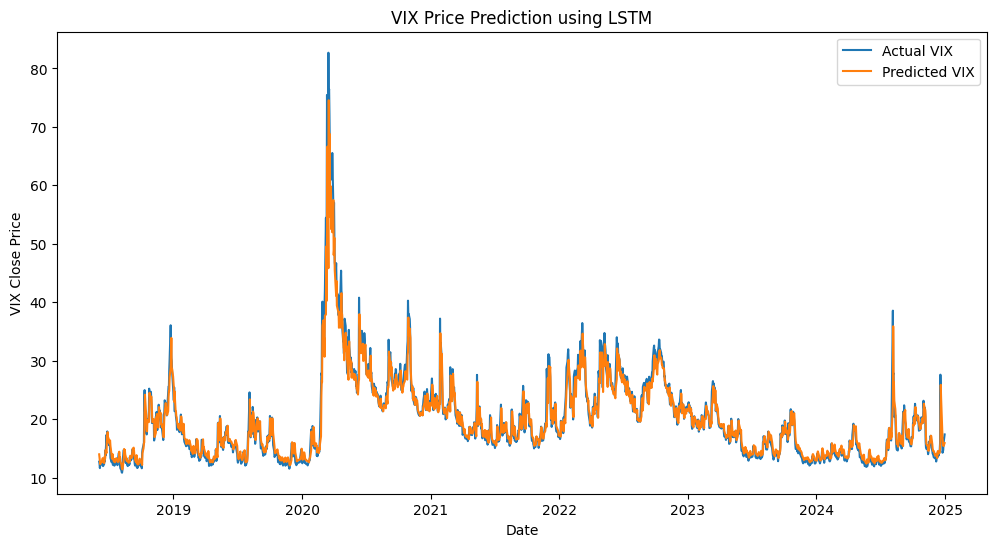

In [ ]:
random.seed(123)
# prompt: build a LSTM model for the prediction of column ^VIX with the variable with lag 5

# Prepare the data for LSTM
# We want to predict '^VIX' based on its past values with lag 5.
# Create lagged features
lag = 5
df_lstm = df[['^VIX']].copy()
for i in range(1, lag + 1):
  df_lstm[f'VIX_lag_{i}'] = df_lstm['^VIX'].shift(i)

df_lstm = df_lstm.dropna()

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_lstm)

# Create sequences for LSTM
def create_sequences(data, seq_length):
  X, y = [], []
  for i in range(len(data) - seq_length):
    X.append(data[i:(i + seq_length), :])
    y.append(data[i + seq_length, 0]) # Predict the current ^VIX value (first column)
  return np.array(X), np.array(y)

seq_length = lag # Use the lag as the sequence length
X, y = create_sequences(scaled_data, seq_length)

# Split data into training and testing sets
train_size = int(len(X) * 0.4)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for LSTM input [samples, timesteps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Build the LSTM model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(units=50, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units=25))
model.add(tf.keras.layers.Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss=tf.keras.losses.Huber())

# Train the model

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_lstm_model.h5', save_best_only=True, monitor='val_loss')

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop, checkpoint]
)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)

# Inverse scale the predictions and actual values
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]
y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df_lstm.index[len(X_train) + lag:], y_test_actual, label='Actual VIX')
plt.plot(df_lstm.index[len(X_train) + lag:], predictions, label='Predicted VIX')
plt.title('VIX Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('VIX Close Price')
plt.legend()
plt.show()

<ipython-input-30-c3189b81eff7>:48: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_strategy['Cumulative_VOO_Returns'] = (1 + df_strategy['VOO'].pct_change()).cumprod().reindex(df_strategy.index).fillna(method='ffill')


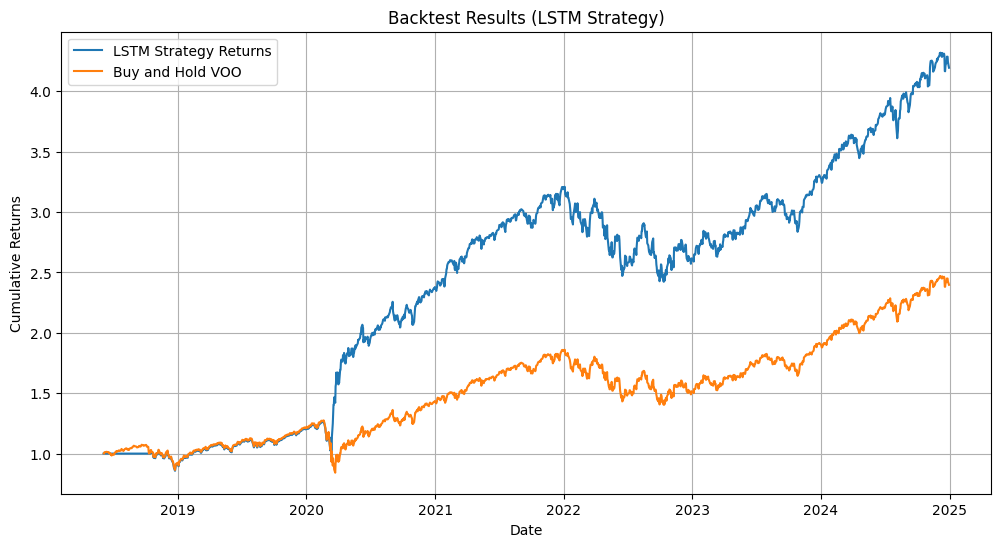

Total LSTM Strategy Return: 319.55%
Total Buy and Hold VOO Return (during LSTM prediction period): 139.78%
LSTM Strategy Sharpe Ratio: 1.21


<ipython-input-30-c3189b81eff7>:63: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strategy_total_return_lstm = (df_strategy['Cumulative_Strategy_Returns_LSTM'][-1] - 1) * 100
<ipython-input-30-c3189b81eff7>:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  buy_and_hold_total_return_lstm = (df_strategy['Cumulative_VOO_Returns'][-1]-1) * 100


In [ ]:
# prompt: Write a code to formulate the strategy by using the prediction from LSTM and generate the buying signal if the prediction is more than 30

# Formulate the strategy based on LSTM prediction
# Add the LSTM predictions to the original dataframe. Need to align by date.
# The predictions correspond to the dates in df_lstm.index[len(X_train) + lag:]
# We need to create a mapping for the dates.

prediction_start = len(X_train) + lag

# Create a Series with proper indexing from df_lstm
lstm_predictions_series = pd.Series(
    predictions,
    index=df_lstm.index[prediction_start:],
    name='LSTM_Prediction'
)

# Add a column for LSTM predictions, initialized with NaNs
df['LSTM_Prediction'] = np.nan

# Insert predictions directly by index alignment (safer than update)
df.loc[lstm_predictions_series.index, 'LSTM_Prediction'] = lstm_predictions_series

# Optionally shift predictions if using for forward-looking signal generation
df['LSTM_Prediction_Shifted'] = df['LSTM_Prediction'].shift(-1)

# Drop rows with no prediction (typically the early rows)
df_strategy = df.dropna(subset=['LSTM_Prediction']).copy()


positions = [0]
# Implement a simple strategy: go long when buy signal is 1, stay in position
df_strategy['Position_LSTM'] = 0
for i in range(1, len(df_strategy)):
  if df_strategy['LSTM_Prediction'].iloc[i] > df_strategy['LSTM_Prediction'].iloc[i-1]+10:
    positions.append(-1)
  elif df_strategy['LSTM_Prediction'].iloc[i] < df_strategy['LSTM_Prediction'].iloc[i-1]-2:
    positions.append(1)
  else:
    positions.append(positions[-1])

df_strategy['Position_LSTM'] = positions
# Calculate daily returns based on the LSTM strategy
df_strategy['Strategy_Returns_LSTM'] = df_strategy['VOO'].pct_change() * df_strategy['Position_LSTM'].shift(1)
df_strategy['Strategy_Returns_LSTM'] = df_strategy['Strategy_Returns_LSTM'].fillna(0)

# Calculate cumulative returns for the LSTM strategy and the benchmark
df_strategy['Cumulative_Strategy_Returns_LSTM'] = (1 + df_strategy['Strategy_Returns_LSTM']).cumprod()
df_strategy['Cumulative_VOO_Returns'] = (1 + df_strategy['VOO'].pct_change()).cumprod().reindex(df_strategy.index).fillna(method='ffill')


# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(df_strategy.index, df_strategy['Cumulative_Strategy_Returns_LSTM'], label='LSTM Strategy Returns')
plt.plot(df_strategy.index, df_strategy['Cumulative_VOO_Returns'], label='Buy and Hold VOO')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Backtest Results (LSTM Strategy)')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate Performance (example metrics)
strategy_total_return_lstm = (df_strategy['Cumulative_Strategy_Returns_LSTM'][-1] - 1) * 100
buy_and_hold_total_return_lstm = (df_strategy['Cumulative_VOO_Returns'][-1]-1) * 100

print(f"Total LSTM Strategy Return: {strategy_total_return_lstm:.2f}%")
print(f"Total Buy and Hold VOO Return (during LSTM prediction period): {buy_and_hold_total_return_lstm:.2f}%")

# Calculate Sharpe Ratio for the LSTM strategy
strategy_sharpe_ratio_lstm = df_strategy['Strategy_Returns_LSTM'].mean() / df_strategy['Strategy_Returns_LSTM'].std() * np.sqrt(252)
print(f"LSTM Strategy Sharpe Ratio: {strategy_sharpe_ratio_lstm:.2f}")

# Count number of buy signals
# num_lstm_buy_signals = df_strategy['LSTM_Signal'].sum()
# print(f"Number of LSTM Buy Signals: {num_lstm_buy_signals}")


In [ ]:
# === LSTM Performance Summary ===
strategy_total_return_lstm = (df_strategy['Cumulative_Strategy_Returns_LSTM'].iloc[-1] - 1) * 100
buy_and_hold_total_return_lstm = (df_strategy['Cumulative_VOO_Returns'].iloc[-1] - 1) * 100
sharpe_lstm = df_strategy['Strategy_Returns_LSTM'].mean() / df_strategy['Strategy_Returns_LSTM'].std() * np.sqrt(252)
num_trades_lstm = df_strategy['Position_LSTM'].diff().abs().sum() / 2  # counts entries/exits


print(f"📈 LSTM Strategy Performance:")
print(f"Total Return: {strategy_total_return_lstm:.2f}%")
print(f"Buy & Hold Return: {buy_and_hold_total_return_lstm:.2f}%")
print(f"Sharpe Ratio: {sharpe_lstm:.2f}")
print(f"Number of Trades: {int(num_trades_lstm)}")

📈 LSTM Strategy Performance:
Total Return: 319.55%
Buy & Hold Return: 139.78%
Sharpe Ratio: 1.21
Number of Trades: 14


In [ ]:
# Define signal: LSTM forecast implies trend, GARCH implies volatility rising
df_strategy['LSTM_GARCH_Signal'] = 0
for i in range(1, len(df_strategy)):
      if (
          df_strategy['LSTM_Prediction'].iloc[i] < df_strategy['LSTM_Prediction'].iloc[i-1] -2 and
          df_strategy['GARCH Buy Signal'].iloc[i] == 1
      ):
          df_strategy.at[df_strategy.index[i], 'LSTM_GARCH_Signal'] = 1  # Buy
      elif (
          df_strategy['LSTM_Prediction'].iloc[i] > df_strategy['LSTM_Prediction'].iloc[i-1] + 10 and
          df_strategy['GARCH Sell Signal'].iloc[i] == 1
      ):
          df_strategy.at[df_strategy.index[i], 'LSTM_GARCH_Signal'] = -1  # Sell
      else:
          df_strategy.at[df_strategy.index[i], 'LSTM_GARCH_Signal'] = df_strategy.at[df_strategy.index[i-1], 'LSTM_GARCH_Signal']

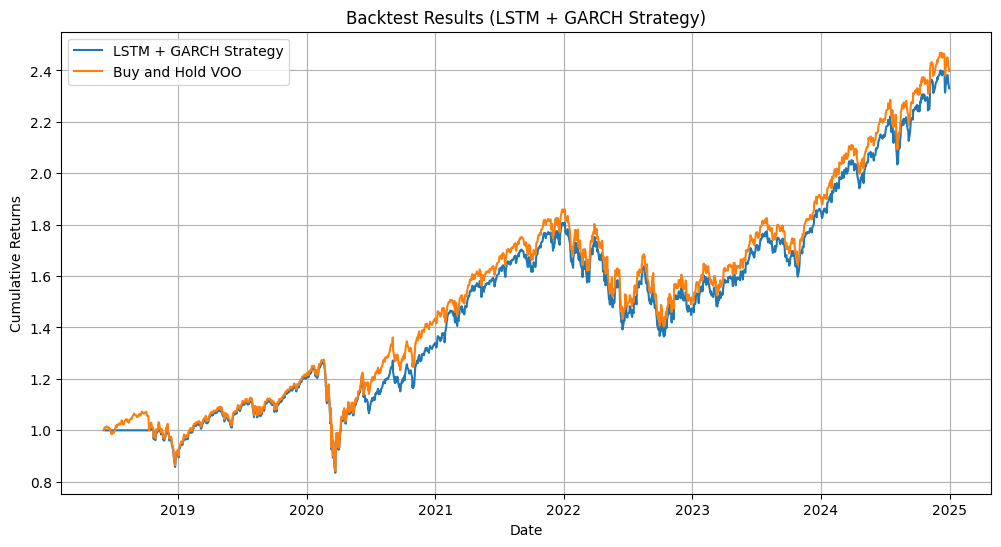

LSTM + GARCH Strategy Performance:
Total Return: 133.06%
Sharpe Ratio: 0.75
Number of Trades: 4


In [ ]:
# Calculate hybrid strategy returns
df_strategy['Strategy_Returns_LSTM_GARCH'] = df_strategy['VOO'].pct_change() * df_strategy['LSTM_GARCH_Signal'].shift(1)
df_strategy['Strategy_Returns_LSTM_GARCH'] = df_strategy['Strategy_Returns_LSTM_GARCH'].fillna(0)
df_strategy['Cumulative_Strategy_Returns_LSTM_GARCH'] = (1 + df_strategy['Strategy_Returns_LSTM_GARCH']).cumprod()
df_strategy['Cumulative_VOO_Returns_LSTM_GARCH'] = (1 + df_strategy['VOO'].pct_change()).cumprod()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df_strategy.index, df_strategy['Cumulative_Strategy_Returns_LSTM_GARCH'], label='LSTM + GARCH Strategy')
plt.plot(df_strategy.index, df_strategy['Cumulative_VOO_Returns_LSTM_GARCH'], label='Buy and Hold VOO')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Backtest Results (LSTM + GARCH Strategy)')
plt.legend()
plt.grid(True)
plt.show()

# Metrics
sharpe_lstm_garch = df_strategy['Strategy_Returns_LSTM_GARCH'].mean() / df_strategy['Strategy_Returns_LSTM_GARCH'].std() * np.sqrt(252)
total_return_lstm_garch = (df_strategy['Cumulative_Strategy_Returns_LSTM_GARCH'].iloc[-1] - 1) * 100
num_trades_lstm_garch = df_strategy['LSTM_GARCH_Signal'].diff().abs().sum() / 2

print(f"LSTM + GARCH Strategy Performance:")
print(f"Total Return: {total_return_lstm_garch:.2f}%")
print(f"Sharpe Ratio: {sharpe_lstm_garch:.2f}")
print(f"Number of Trades: {int(num_trades_lstm_garch)}")


**Enhancements**

In [ ]:
# Recreate LSTM-based signal: long when prediction is dropping significantly, short when rising
df['Position_LSTM'] = 0

for i in range(1, len(df)):
    if (
        pd.notna(df['LSTM_Prediction'].iloc[i])
        and pd.notna(df['LSTM_Prediction'].iloc[i - 1])
    ):
        if df['LSTM_Prediction'].iloc[i] < df['LSTM_Prediction'].iloc[i - 1] - 2:
            df.iloc[i, df.columns.get_loc('Position_LSTM')] = 1  # Long VOO
        elif df['LSTM_Prediction'].iloc[i] > df['LSTM_Prediction'].iloc[i - 1] + 10:
            df.iloc[i, df.columns.get_loc('Position_LSTM')] = -1  # Short VOO
        else:
            df.iloc[i, df.columns.get_loc('Position_LSTM')] = df.iloc[i - 1, df.columns.get_loc('Position_LSTM')]
    else:
        df.iloc[i, df.columns.get_loc('Position_LSTM')] = df.iloc[i - 1, df.columns.get_loc('Position_LSTM')]

# Assumes GARCH forecast and realized std dev already exist
df['GARCH Signal'] = np.where(df['GARCH predict shift 1'] > df['VOO pct change sd'], 1, 0)
df['Position_GARCH'] = df['GARCH Signal']

# Split data by regime
regime_0 = df[df['Regime'] == 0]
regime_1 = df[df['Regime'] == 1]

# LSTM in Regime 0
lstm_return_0 = (regime_0['VOO'].pct_change() * regime_0['Position_LSTM'].shift(1)).dropna()
sharpe_lstm_0 = lstm_return_0.mean() / lstm_return_0.std() * np.sqrt(252)
total_lstm_0 = (1 + lstm_return_0).prod() - 1

# GARCH in Regime 0
garch_return_0 = (regime_0['VOO'].pct_change() * regime_0['Position_GARCH'].shift(1)).dropna()
sharpe_garch_0 = garch_return_0.mean() / garch_return_0.std() * np.sqrt(252)
total_garch_0 = (1 + garch_return_0).prod() - 1

# LSTM in Regime 1
lstm_return_1 = (regime_1['VOO'].pct_change() * regime_1['Position_LSTM'].shift(1)).dropna()
sharpe_lstm_1 = lstm_return_1.mean() / lstm_return_1.std() * np.sqrt(252)
total_lstm_1 = (1 + lstm_return_1).prod() - 1

# GARCH in Regime 1
garch_return_1 = (regime_1['VOO'].pct_change() * regime_1['Position_GARCH'].shift(1)).dropna()
sharpe_garch_1 = garch_return_1.mean() / garch_return_1.std() * np.sqrt(252)
total_garch_1 = (1 + garch_return_1).prod() - 1

# Print results
print("Performance by Regime:\n")
print("Regime 0 (calm):")
print(f"  LSTM -> Sharpe: {sharpe_lstm_0:.2f}, Total Return: {total_lstm_0*100:.2f}%")
print(f"  GARCH -> Sharpe: {sharpe_garch_0:.2f}, Total Return: {total_garch_0*100:.2f}%\n")

print("Regime 1 (volatile):")
print(f"  LSTM -> Sharpe: {sharpe_lstm_1:.2f}, Total Return: {total_lstm_1*100:.2f}%")
print(f"  GARCH -> Sharpe: {sharpe_garch_1:.2f}, Total Return: {total_garch_1*100:.2f}%")


Performance by Regime:

Regime 0 (calm):
  LSTM -> Sharpe: 1.10, Total Return: 140.61%
  GARCH -> Sharpe: 1.68, Total Return: 151.86%

Regime 1 (volatile):
  LSTM -> Sharpe: 1.29, Total Return: 321.35%
  GARCH -> Sharpe: 1.00, Total Return: 247.38%


In [ ]:
df['VOO_pct'] = df['VOO'].pct_change()
df['GARCH_pred'] = df['GARCH predict'].shift(1)
df['RSI_14'] = df['VIX RSI']
df['VIX_5d_avg'] = df['^VIX'].rolling(5).mean()
df['VIX_change'] = df['^VIX'].pct_change()
df['VOO_gap'] = df['VOO_pct'].shift(-1) - df['VOO_pct']
df['log_VIX'] = np.log(df['^VIX'])

# Define final features
features = ['VOO_pct', 'GARCH_pred', 'RSI_14',
            'VIX_5d_avg', 'VIX_change', 'VOO_gap']

# Target variations
df = df.dropna().copy()
scalers = {col: MinMaxScaler() for col in features}
for col in features:
    df[col] = scalers[col].fit_transform(df[[col]])
lag = 5
for col in features:
    for i in range(1, lag + 1):
        df[f'{col}_lag_{i}'] = df[col].shift(i)

df_lstm_all = df.dropna().copy()
def create_sequences(data, feature_cols, target_col, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[feature_cols].iloc[i:i+seq_len].values)
        y.append(data[target_col].iloc[i+seq_len])
    return np.array(X), np.array(y)

feature_cols = [f'{col}_lag_{i}' for col in features for i in range(1, lag + 1)]
# Model A: Predict raw VIX
X_a, y_a = create_sequences(df_lstm_all, feature_cols, '^VIX', lag)

# Model B: Predict log(VIX)
X_b, y_b = create_sequences(df_lstm_all, feature_cols, 'log_VIX', lag)

# Model C: Predict log(VIX) with deeper + bidirectional model
X_c, y_c = X_b.copy(), y_b.copy()  # same inputs/target as Model B

train_size = int(len(X_a) * 0.4)
X_train_a, X_test_a = X_a[:train_size], X_a[train_size:]
y_train_a, y_test_a = y_a[:train_size], y_a[train_size:]

X_train_b, X_test_b = X_b[:train_size], X_b[train_size:]
y_train_b, y_test_b = y_b[:train_size], y_b[train_size:]

X_train_c, X_test_c = X_c[:train_size], X_c[train_size:]
y_train_c, y_test_c = y_c[:train_size], y_c[train_size:]


In [ ]:
model_a = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train_a.shape[1], X_train_a.shape[2])),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
model_a.compile(optimizer='adam', loss='huber')
model_a.fit(X_train_a, y_train_a, epochs=100, batch_size=32, validation_split=0.1,
            callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)], verbose=1)
y_pred_a = model_a.predict(X_test_a).flatten()


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 19.6017 - val_loss: 17.8489
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 10.9483 - val_loss: 6.1273
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.2468 - val_loss: 6.4797
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 7.1102 - val_loss: 7.5975
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 6.4132 - val_loss: 7.0978
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.7694 - val_loss: 7.2976
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 6.5919 - val_loss: 7.1115
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.0669 - val_loss: 7.4472
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.2155 - val_loss: 7.2118
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.6632 - val_loss: 7.0919
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.4367 - val_loss: 7.5120
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 

In [ ]:
model_b = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train_b.shape[1], X_train_b.shape[2])),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
model_b.compile(optimizer='adam', loss='huber')
model_b.fit(X_train_b, y_train_b, epochs=100, batch_size=32, validation_split=0.1,
            callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)], verbose=1)
y_pred_b = np.exp(model_b.predict(X_test_b).flatten())


Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 1.9908 - val_loss: 0.1988
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2575 - val_loss: 0.0281
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0910 - val_loss: 0.0388
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0766 - val_loss: 0.0245
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0608 - val_loss: 0.0220
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0511 - val_loss: 0.0190
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0512 - val_loss: 0.0267
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0411 - val_loss: 0.0148
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0430 - val_loss: 0.0174
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0375 - val_loss: 0.0161
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0356 - val_loss: 0.0123
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step

In [ ]:
model_c = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train_c.shape[1], X_train_c.shape[2])),
    Dropout(0.3),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(32, activation='relu'),
    Dense(1)
])
model_c.compile(optimizer='adam', loss='huber')
model_c.fit(X_train_c, y_train_c, epochs=100, batch_size=32, validation_split=0.1,
            callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)], verbose=1)
y_pred_c = np.exp(model_c.predict(X_test_c).flatten())


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - loss: 2.1451 - val_loss: 0.5506
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1973 - val_loss: 0.0229
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0839 - val_loss: 0.0271
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0825 - val_loss: 0.0488
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0759 - val_loss: 0.0354
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0752 - val_loss: 0.0374
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0790 - val_loss: 0.0417
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0762 - val_loss: 0.0291
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0673 - val_loss: 0.0193
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0621 - val_loss: 0.0141
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0371 - val_loss: 0.0215
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.

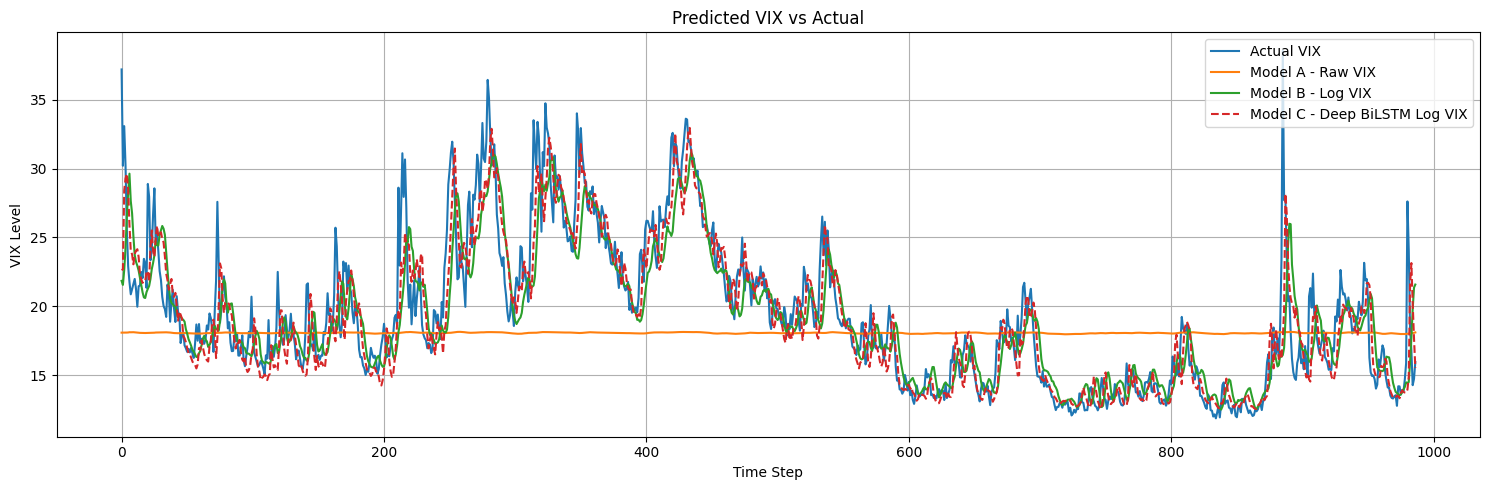

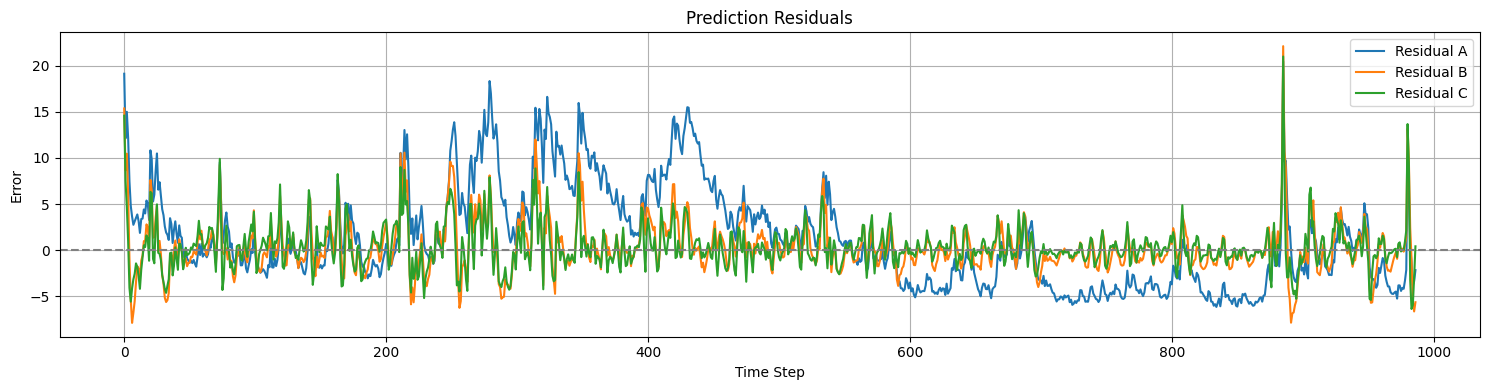


📈 Model A - Raw VIX
Mean Squared Error : 29.5908
Mean Absolute Error: 4.1517

📈 Model B - Log VIX
Mean Squared Error : 7.8450
Mean Absolute Error: 1.8799

📈 Model C - Deep BiLSTM Log VIX
Mean Squared Error : 5.7677
Mean Absolute Error: 1.6041


In [ ]:
# --- Step 1: Actual Series (same for all)
actual_vix = y_test_a  # raw VIX (used in all 3)

# --- Step 2: Error Metrics Function ---
def print_error_metrics(y_true, y_pred, label):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"\n📈 {label}")
    print(f"Mean Squared Error : {mse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    return mse, mae

# --- Step 3: Plot Actual vs Predicted ---
plt.figure(figsize=(15, 5))
plt.plot(actual_vix, label='Actual VIX', linewidth=1.5)
plt.plot(y_pred_a, label='Model A - Raw VIX')
plt.plot(y_pred_b, label='Model B - Log VIX')
plt.plot(y_pred_c, label='Model C - Deep BiLSTM Log VIX', linestyle='--')
plt.title("Predicted VIX vs Actual")
plt.xlabel("Time Step")
plt.ylabel("VIX Level")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Step 4: Plot Residuals ---
plt.figure(figsize=(15, 4))
plt.plot(actual_vix - y_pred_a, label='Residual A')
plt.plot(actual_vix - y_pred_b, label='Residual B')
plt.plot(actual_vix - y_pred_c, label='Residual C')
plt.title("Prediction Residuals")
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Time Step")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Step 5: Print Metrics ---
metrics_a = print_error_metrics(actual_vix, y_pred_a, "Model A - Raw VIX")
metrics_b = print_error_metrics(actual_vix, y_pred_b, "Model B - Log VIX")
metrics_c = print_error_metrics(actual_vix, y_pred_c, "Model C - Deep BiLSTM Log VIX")


Signal distribution:
  0    592
-1    197
 1    197
Name: count, dtype: int64
Cumulative return end value: 0.7214997122228695


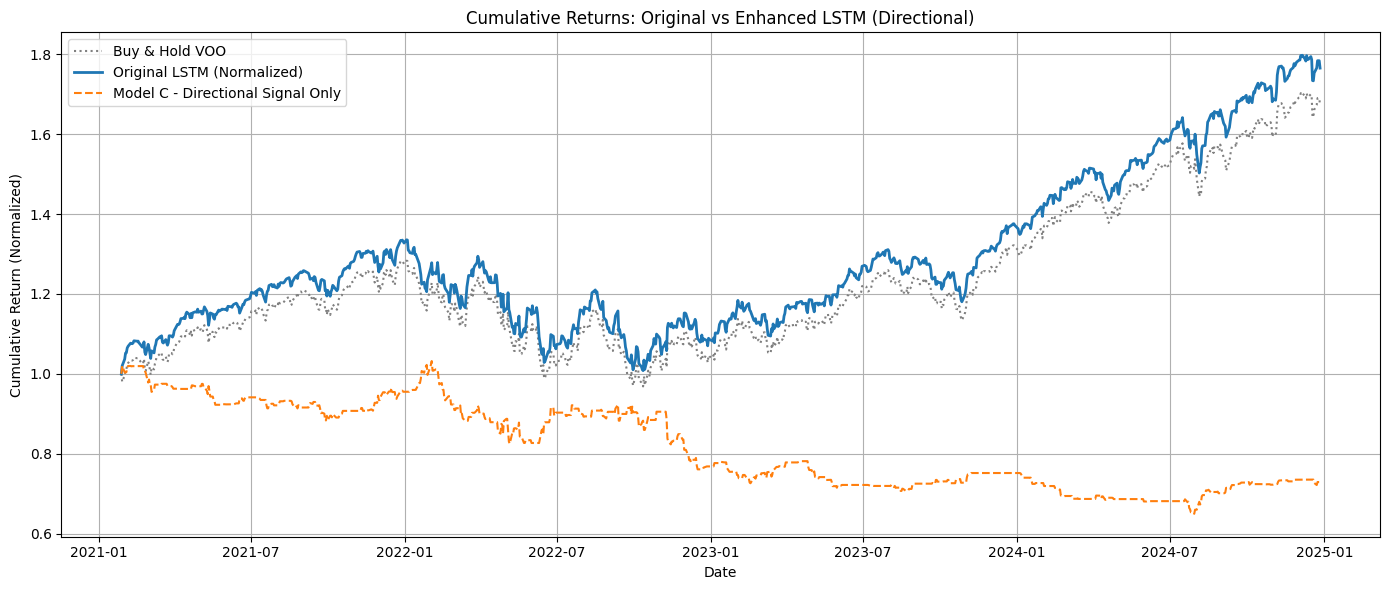

In [ ]:
# --- Step 1: Compute VIX prediction change ---
vix_pred_diff_c = pd.Series(y_pred_c, index=df_lstm_all.index[-len(y_pred_c):]).diff().dropna()

# --- Step 2: Dynamic threshold based on distribution ---
lower, upper = np.percentile(vix_pred_diff_c, [20, 80])

signals_c = pd.Series(
    np.where(vix_pred_diff_c < lower, 1,  # Long on VIX falling
             np.where(vix_pred_diff_c > upper, -1, 0)),
    index=vix_pred_diff_c.index
)

# --- Step 3: Align to SPY or VOO returns ---
returns = df['VOO'].pct_change().reindex(signals_c.index).fillna(0)
strategy_returns_c = signals_c * returns
strategy_returns_c = strategy_returns_c.clip(lower=-0.1, upper=0.1)  # safety cap

# --- Step 4: Cumulative Returns ---
cumulative_returns_c = (1 + strategy_returns_c).cumprod()

# Save for next charting block if needed:
signals_model_c = signals_c.copy()
strategy_returns_model_c = strategy_returns_c.copy()
cumulative_returns_model_c = cumulative_returns_c.copy()

# --- Optional quick summary ---
print("Signal distribution:\n", signals_c.value_counts())
print("Cumulative return end value:", cumulative_returns_c.iloc[-1])

# --- Normalize original LSTM to start at 1 ---
aligned_original_lstm = df_strategy['Cumulative_Strategy_Returns_LSTM']
aligned_original_lstm = aligned_original_lstm.reindex(cumulative_returns_model_c.index).dropna()
aligned_original_lstm /= aligned_original_lstm.iloc[0]

# --- Recompute Buy & Hold baseline (normalize too) ---
buy_hold_returns = (1 + df['VOO'].pct_change().reindex(cumulative_returns_model_c.index).fillna(0)).cumprod()
buy_hold_returns /= buy_hold_returns.iloc[0]

# --- Plot again ---
plt.figure(figsize=(14, 6))
plt.plot(buy_hold_returns, label='Buy & Hold VOO', linestyle=':', color='gray')
plt.plot(aligned_original_lstm, label='Original LSTM (Normalized)', linewidth=2)
plt.plot(cumulative_returns_model_c, label='Model C - Directional Signal Only', linestyle='--')
plt.title("Cumulative Returns: Original vs Enhanced LSTM (Directional)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (Normalized)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


    Upper  Lower  Cumulative Return    Sharpe  Volatility
51     11     -4           3.615045  1.311466    0.191541
41     10     -4           3.615045  1.311466    0.191541
32      9     -4           3.298265  1.254612    0.191596
60     12     -5           3.255942  1.246727    0.191604
61     12     -4           3.255942  1.246727    0.191604


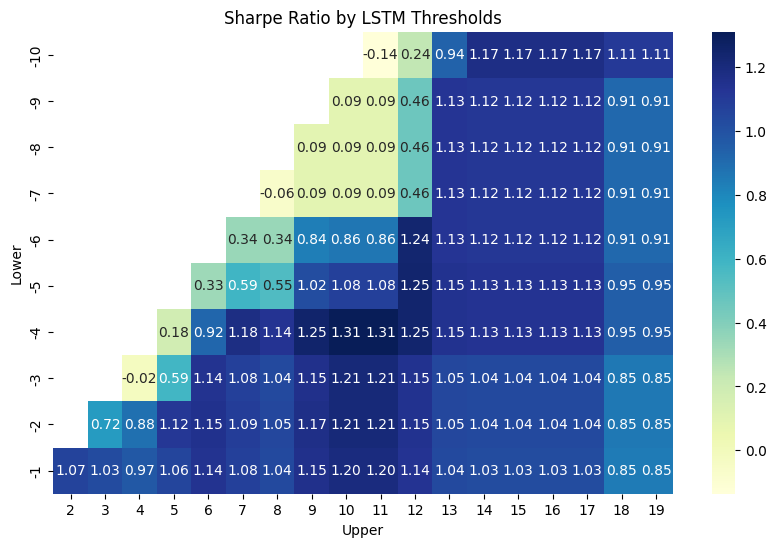

In [ ]:
# Define grid of thresholds
upper_range = np.arange(1, 20, 1)   # 5 to 15
lower_range = np.arange(-10, 0, 1)   # -5 to -1

results = []

# Ensure you're working with a copy
df_search = df_strategy.copy()

for upper in upper_range:
    for lower in lower_range:
        # Skip illogical combinations
        if upper <= abs(lower):
            continue

        # Generate signal
        positions = [0]
        for i in range(1, len(df_search)):
            prev = df_search['LSTM_Prediction'].iloc[i-1]
            curr = df_search['LSTM_Prediction'].iloc[i]

            if curr > prev + upper:
                positions.append(-1)
            elif curr < prev + lower:
                positions.append(1)
            else:
                positions.append(positions[-1])  # hold

        df_search['Grid_Position'] = positions

        # Calculate strategy returns
        df_search['Grid_Returns'] = df_search['VOO'].pct_change() * df_search['Grid_Position'].shift(1)
        df_search['Grid_Returns'] = df_search['Grid_Returns'].fillna(0)

        # Evaluate performance
        cumulative_return = (1 + df_search['Grid_Returns']).prod() - 1
        annualized_vol = df_search['Grid_Returns'].std() * np.sqrt(252)
        sharpe = df_search['Grid_Returns'].mean() / df_search['Grid_Returns'].std() * np.sqrt(252)

        results.append({
            'Upper': upper,
            'Lower': lower,
            'Cumulative Return': cumulative_return,
            'Sharpe': sharpe,
            'Volatility': annualized_vol
        })

# Create results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Sharpe', ascending=False)


# Top results
print(results_df.head(5))

# Heatmap (Sharpe)
pivot = results_df.pivot(index='Lower', columns='Upper', values='Sharpe')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap='YlGnBu')
plt.title("Sharpe Ratio by LSTM Thresholds")
plt.show()


In [ ]:
# --- Step 1: Apply Optimal Thresholds ---
upper_opt = 2
lower_opt = -1

positions_opt = [0]
for i in range(1, len(df_strategy)):
    prev = df_strategy['LSTM_Prediction'].iloc[i-1]
    curr = df_strategy['LSTM_Prediction'].iloc[i]

    if curr > prev + upper_opt:
        positions_opt.append(-1)
    elif curr < prev + lower_opt:
        positions_opt.append(1)
    else:
        positions_opt.append(positions_opt[-1])

df_strategy['Position_LSTM_Optimized'] = positions_opt

# --- Step 2: Strategy Returns ---
returns_opt = df_strategy['VOO'].pct_change().fillna(0)
strategy_returns_opt = returns_opt * df_strategy['Position_LSTM_Optimized'].shift(1).fillna(0)
cumulative_returns_opt = (1 + strategy_returns_opt).cumprod()

# Normalize for comparison
cumulative_returns_opt /= cumulative_returns_opt.iloc[0]
buy_hold = (1 + returns_opt).cumprod()
buy_hold /= buy_hold.iloc[0]



Strategy                 Return   Volatility     Sharpe    Max Drawdown
Buy & Hold               139.78%        19.81%       0.77           45.61%
Original LSTM            319.55%        19.64%       1.21           78.70%
Optimized LSTM           251.21%        19.78%       1.07           89.00%


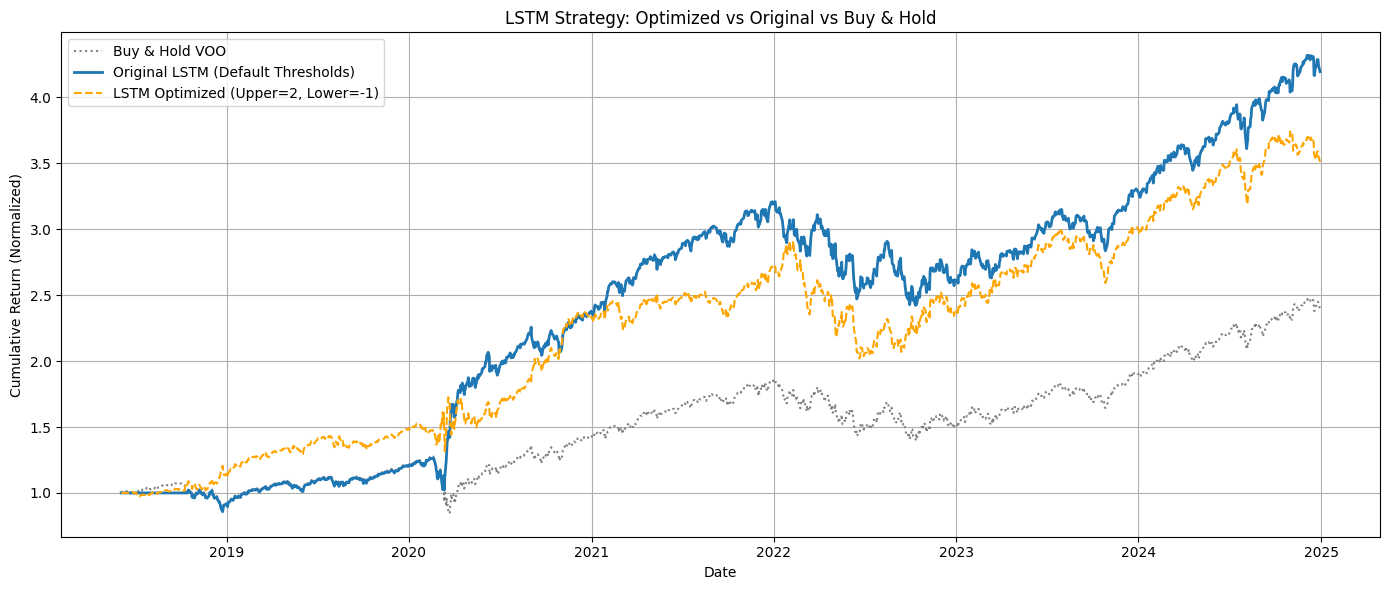

In [ ]:
# --- Step 1: Strategy Returns ---
returns_opt = df_strategy['VOO'].pct_change().fillna(0)
buy_hold_returns = returns_opt.copy()
lstm_returns_default = df_strategy['Strategy_Returns_LSTM'].fillna(0)
lstm_returns_opt = returns_opt * df_strategy['Position_LSTM_Optimized'].shift(1).fillna(0)

# --- Step 2: Cumulative Returns ---
cumulative_buy_hold = (1 + buy_hold_returns).cumprod()
cumulative_buy_hold /= cumulative_buy_hold.iloc[0]

cumulative_lstm_default = df_strategy['Cumulative_Strategy_Returns_LSTM'].dropna()
cumulative_lstm_default /= cumulative_lstm_default.iloc[0]

cumulative_lstm_opt = (1 + lstm_returns_opt).cumprod()
cumulative_lstm_opt /= cumulative_lstm_opt.iloc[0]

# --- Step 3: Define Performance Metric Function ---
def compute_metrics(returns):
    returns = returns.dropna()
    cumulative_return = (1 + returns).prod() - 1
    annualized_vol = returns.std() * np.sqrt(252)
    sharpe = returns.mean() / returns.std() * np.sqrt(252)
    cumulative = (1 + returns).cumprod()
    drawdown = (cumulative.cummax() - cumulative).max()
    return cumulative_return, annualized_vol, sharpe, drawdown

# --- Step 4: Compute Metrics ---
metrics = {
    'Buy & Hold': compute_metrics(buy_hold_returns),
    'Original LSTM': compute_metrics(lstm_returns_default),
    'Optimized LSTM': compute_metrics(lstm_returns_opt)
}

# --- Step 5: Print Results ---
print(f"{'Strategy':<20} {'Return':>10} {'Volatility':>12} {'Sharpe':>10} {'Max Drawdown':>15}")
for name, (ret, vol, sharpe, dd) in metrics.items():
    print(f"{name:<20} {ret*100:10.2f}% {vol*100:12.2f}% {sharpe:10.2f} {dd*100:15.2f}%")

# --- Step 6: Plot ---
plt.figure(figsize=(14, 6))
plt.plot(cumulative_buy_hold, label='Buy & Hold VOO', linestyle=':', color='gray')
plt.plot(cumulative_lstm_default, label='Original LSTM (Default Thresholds)', linewidth=2)
plt.plot(cumulative_lstm_opt, label=f'LSTM Optimized (Upper={upper_opt}, Lower={lower_opt})', linestyle='--', color='orange')

plt.title("LSTM Strategy: Optimized vs Original vs Buy & Hold")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (Normalized)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Consolidation and Comparison

In [ ]:
#Consolidate previous calculated returns of all strategies
df_compare['Buy and Hold_Returns'] = buy_hold_returns
df_compare['Cumulative_Buy_and_Hold_Returns'] = cumulative_buy_hold


df_compare['Original LSTM Position'] = df_strategy['Position_LSTM']
df_compare['Original LSTM Strategy_Returns'] = df_strategy['Strategy_Returns_LSTM']
df_compare['Cumulative_Original_LSTM_Strategy_Returns'] = cumulative_lstm_default


df_compare['LSTM Optimized (Grid Search) Position'] = df_strategy['Position_LSTM_Optimized']
df_compare['LSTM Optimized (Grid Search) Strategy_Returns'] = strategy_returns_opt
df_compare['Cumulative_LSTM Optimized (Grid Search)_Strategy_Returns'] = cumulative_lstm_opt

df_compare['VIX GARCH Position'] = df['VIX GARCH Position']
df_compare['VIX GARCH Strategy_Returns'] = df['VIX GARCH Strategy_Returns']
df_compare['Cumulative_VIX_GARCH_Strategy_Returns'] = df['Cumulative_VIX_GARCH_Strategy_Returns']

df_compare['LSTM GARCH Position'] = df_strategy['LSTM_GARCH_Signal']
df_compare['LSTM GARCH Strategy_Returns'] = df_strategy['Strategy_Returns_LSTM_GARCH']
df_compare['Cumulative_LSTM GARCH_Strategy_Returns'] = df_strategy['Cumulative_Strategy_Returns_LSTM_GARCH']

In [ ]:
#Calculate again the cumulative returns starting from the same start date
df_compare = df_compare.dropna()
df_compare['Cumulative_Buy_and_Hold_Returns'] = (1 + df_compare['Buy and Hold_Returns']).cumprod()
df_compare['Cumulative_VIX_base_Strategy_Returns'] = (1 + df_compare['VIX base Strategy_Returns']).cumprod()
df_compare['Cumulative_VIX_RSI_Strategy_Returns'] = (1 + df_compare['VIX RSI Strategy_Returns']).cumprod()
df_compare['Cumulative_VIX_GARCH_Strategy_Returns'] = (1 + df_compare['VIX GARCH Strategy_Returns']).cumprod()
df_compare['Cumulative_Original_LSTM_Strategy_Returns'] = (1 + df_compare['Original LSTM Strategy_Returns']).cumprod()
df_compare['Cumulative_LSTM Optimized (Grid Search)_Strategy_Returns'] = (1 + df_compare['LSTM Optimized (Grid Search) Strategy_Returns']).cumprod()
df_compare['Cumulative_LSTM GARCH_Strategy_Returns'] = (1 + df_compare['LSTM GARCH Strategy_Returns']).cumprod()

<ipython-input-45-b61e5f7f72fd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_compare['Cumulative_Buy_and_Hold_Returns'] = (1 + df_compare['Buy and Hold_Returns']).cumprod()
<ipython-input-45-b61e5f7f72fd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_compare['Cumulative_VIX_base_Strategy_Returns'] = (1 + df_compare['VIX base Strategy_Returns']).cumprod()
<ipython-input-45-b61e5f7f72fd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [ ]:
def compute_metrics(returns, positions=None, name='Strategy'):
    returns = returns.dropna()
    cumulative_return = (1 + returns).prod() - 1
    annualized_vol = returns.std() * np.sqrt(252)
    sharpe = returns.mean() / returns.std() * np.sqrt(252)
    cumulative = (1 + returns).cumprod()
    drawdown = (cumulative.cummax() - cumulative).max()
    trade_count = (positions.diff().fillna(0) != 0).sum() if positions is not None else np.nan

    return {
        'Strategy': name,
        'Total Return': f"{cumulative_return*100:.2f}%",
        'Sharpe Ratio': f"{sharpe:.2f}",
        'Max Drawdown': f"{drawdown*100:.2f}%",
        'Trades': trade_count
    }

# --- Define strategy returns and positions ---
metrics_all = []

metrics_all.append(compute_metrics(df_compare['Buy and Hold_Returns'], name="Buy & Hold"))

metrics_all.append(compute_metrics(df_compare['VIX base Strategy_Returns'],
                                   df_compare['VIX base Position'],
                                   name="VIX Base"))

metrics_all.append(compute_metrics(df_compare['VIX RSI Strategy_Returns'],
                                   df_compare['VIX RSI Position'],
                                   name="VIX and RSI"))

metrics_all.append(compute_metrics(df_compare['VIX GARCH Strategy_Returns'],
                                   df_compare['VIX GARCH Position'],
                                   name="VIX and GARCH"))

metrics_all.append(compute_metrics(df_compare['Original LSTM Strategy_Returns'],
                                   df_compare['Original LSTM Position'],
                                   name="Original LSTM"))

metrics_all.append(compute_metrics(df_compare['LSTM Optimized (Grid Search) Strategy_Returns'],
                                   df_compare['LSTM Optimized (Grid Search) Position'],
                                   name="LSTM Optimized"))

metrics_all.append(compute_metrics(df_compare['LSTM GARCH Strategy_Returns'],
                                   df_compare['LSTM GARCH Position'],
                                   name="LSTM GARCH"))

# --- Compile and display ---
summary_df = pd.DataFrame(metrics_all)
summary_df.set_index('Strategy', inplace=True)
summary_df.index.name = None
print(summary_df)
summary_df.to_csv('summary.csv')

               Total Return Sharpe Ratio Max Drawdown  Trades
Buy & Hold          142.48%         0.78       45.61%     NaN
VIX Base            115.83%         0.69       41.55%     6.0
VIX and RSI         115.83%         0.69       41.55%     6.0
VIX and GARCH       139.27%         0.77       45.72%     4.0
Original LSTM       324.28%         1.22       78.70%    15.0
LSTM Optimized      255.16%         1.08       89.00%   156.0
LSTM GARCH          135.68%         0.76       44.33%     5.0


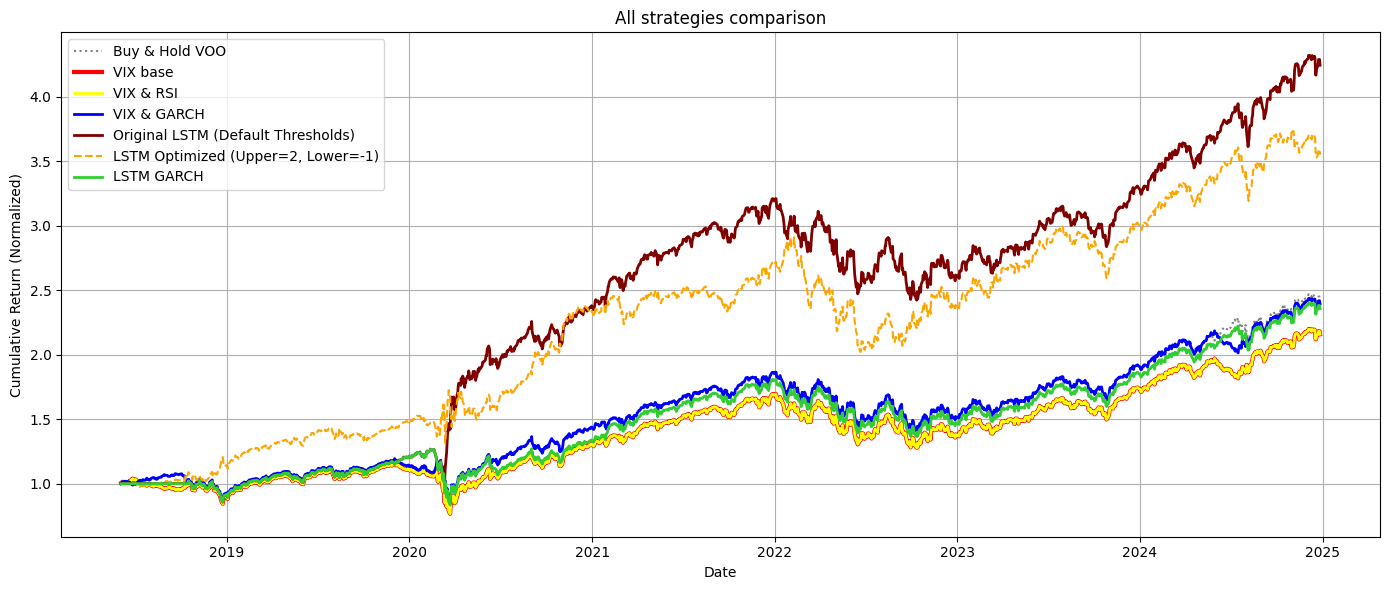

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(df_compare['Cumulative_Buy_and_Hold_Returns'], label='Buy & Hold VOO', linestyle=':', color='gray')
plt.plot(df_compare['Cumulative_VIX_base_Strategy_Returns'], label='VIX base', linewidth=3,color='red')
plt.plot(df_compare['Cumulative_VIX_RSI_Strategy_Returns'], label='VIX & RSI', linewidth=2,color='yellow')
plt.plot(df_compare['Cumulative_VIX_GARCH_Strategy_Returns'], label='VIX & GARCH', linewidth=2,color='blue')
plt.plot(df_compare['Cumulative_Original_LSTM_Strategy_Returns'], label='Original LSTM (Default Thresholds)', linewidth=2,color='maroon')
plt.plot(df_compare['Cumulative_LSTM Optimized (Grid Search)_Strategy_Returns'], label=f'LSTM Optimized (Upper={upper_opt}, Lower={lower_opt})', linestyle='--', color='orange')
plt.plot(df_compare['Cumulative_LSTM GARCH_Strategy_Returns'], label='LSTM GARCH', linewidth=2,color='limegreen')

plt.title("All strategies comparison")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (Normalized)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()